# MovieLens 100k Softmax DNN Recommender System

In [168]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [196]:
# from keras.models import Model
# from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding
# from keras.optimizers import Adam
# from keras.regularizers import l2
# from keras.layers import Concatenate, Dense, Dropout
# from keras.layers import Add, Activation, Lambda

import tensorflow as tf
import keras
from pprint import pprint

In [170]:
ratings_dataset = pd.read_csv('/Users/stevenmacauda/Downloads/ml-latest-small/ratings.csv')

In [171]:
items_dataset = pd.read_csv('/Users/stevenmacauda/Downloads/ml-latest-small/movies.csv')

In [176]:
movie_dataset = items_dataset[['movieId','title']]
movie_dataset.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [178]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movieId')
merged_dataset.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [180]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0


In [182]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['userId'].values)
n_users = refined_dataset['user'].nunique()

In [183]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['title'].values)
n_movies = refined_dataset['movie'].nunique()

In [184]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9719, 0.5, 5.0)

In [186]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90748, 2), (10084, 2), (90748,), (10084,))

In [187]:
n_factors = 150

In [188]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [189]:
X_train, X_train_array, X_train_array[0].shape

(array([[ 476, 2766],
        [ 155, 4464],
        [ 306, 8391],
        ...,
        [ 312, 5139],
        [ 154,  591],
        [  88, 8559]]),
 [array([476, 155, 306, ..., 312, 154,  88]),
  array([2766, 4464, 8391, ..., 5139,  591, 8559])],
 (90748,))

In [190]:

y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

In [199]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [200]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 150)       91500       ['input_7[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 150)       1457850     ['input_8[0][0]']                
                                                                                              

In [201]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/70


2022-08-11 18:24:40.048832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


709/709 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.0147

2022-08-11 18:24:56.054220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


709/709 [==============================] - 17s 17ms/step - loss: 0.6360 - accuracy: 0.0147 - val_loss: 0.4053 - val_accuracy: 0.0137 - lr: 0.0100
Epoch 2/70
709/709 [==============================] - 11s 16ms/step - loss: 0.3983 - accuracy: 0.0136 - val_loss: 0.3957 - val_accuracy: 0.0137 - lr: 0.0100
Epoch 3/70
709/709 [==============================] - 12s 17ms/step - loss: 0.3922 - accuracy: 0.0136 - val_loss: 0.3928 - val_accuracy: 0.0137 - lr: 0.0100
Epoch 4/70
709/709 [==============================] - 11s 16ms/step - loss: 0.3900 - accuracy: 0.0136 - val_loss: 0.3913 - val_accuracy: 0.0137 - lr: 0.0100
Epoch 5/70
709/709 [==============================] - 11s 16ms/step - loss: 0.3884 - accuracy: 0.0136 - val_loss: 0.3897 - val_accuracy: 0.0137 - lr: 0.0100
Epoch 6/70
709/709 [==============================] - 11s 16ms/step - loss: 0.3867 - accuracy: 0.0136 - val_loss: 0.3881 - val_accuracy: 0.0137 - lr: 0.0100
Epoch 7/70
709/709 [==============================] - 12s 16ms/step -

Epoch 52/70
709/709 [==============================] - 12s 18ms/step - loss: 0.2853 - accuracy: 0.0457 - val_loss: 0.3118 - val_accuracy: 0.0384 - lr: 0.0075
Epoch 53/70
709/709 [==============================] - 13s 18ms/step - loss: 0.2841 - accuracy: 0.0460 - val_loss: 0.3111 - val_accuracy: 0.0415 - lr: 0.0075
Epoch 54/70
709/709 [==============================] - 12s 18ms/step - loss: 0.2834 - accuracy: 0.0472 - val_loss: 0.3116 - val_accuracy: 0.0401 - lr: 0.0075
Epoch 55/70
709/709 [==============================] - 13s 18ms/step - loss: 0.2830 - accuracy: 0.0470 - val_loss: 0.3112 - val_accuracy: 0.0430 - lr: 0.0075
Epoch 56/70
709/709 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.0471
Epoch 56: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.
709/709 [==============================] - 13s 19ms/step - loss: 0.2820 - accuracy: 0.0471 - val_loss: 0.3122 - val_accuracy: 0.0390 - lr: 0.0075
Epoch 57/70
709/709 [============================

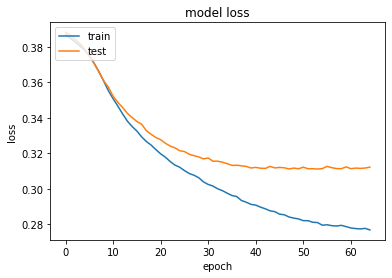

In [202]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [203]:
refined_dataset.head()

,userId,title,rating,user,movie
0,1,"13th Warrior, The (1999)",4.0,0,48
1,1,20 Dates (1998),4.0,0,66
2,1,"Abyss, The (1989)",4.0,0,202
3,1,"Adventures of Robin Hood, The (1938)",5.0,0,245
4,1,Alice in Wonderland (1951),5.0,0,325


In [204]:
X_train_array

[array([476, 155, 306, ..., 312, 154,  88]),
 array([2766, 4464, 8391, ..., 5139,  591, 8559])]

In [207]:
user_id = [476]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['userId'] == user_id[0]]['movie'])
print(seen_movies)

[274, 298, 434, 565, 587, 713, 785, 836, 839, 904, 928, 1106, 1602, 1828, 1832, 1833, 2043, 2139, 2188, 2396, 2478, 2752, 3048, 3158, 3172, 3216, 3279, 3406, 3529, 3567, 3996, 4222, 4309, 4462, 4645, 4654, 4662, 5103, 5144, 5514, 5685, 5722, 5862, 6046, 6335, 6632, 6686, 6775, 6865, 6923, 7165, 7368, 7468, 7483, 7593, 7755, 7805, 7839, 7911, 7912, 7994, 8208, 8363, 8786, 8871, 8949, 8982, 9371, 9403]


In [208]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(9719, 0, 9718)

In [209]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [210]:
len(unseen_movies) + len(seen_movies)

9719

In [211]:

model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 9650)

In [212]:
predicted_ratings = model.predict(model_input)

 23/302 [=>............................] - ETA: 1s

2022-08-11 19:45:38.398507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


302/302 [==============================] - 2s 5ms/step


In [213]:
print(predicted_ratings.shape)

(9650, 9)


In [214]:
print(predicted_ratings)

[[9.21854913e-01 7.79975206e-02 1.29161026e-05 ... 2.69522079e-05
  1.15029443e-05 1.41337969e-05]
 [9.01649892e-01 9.81897786e-02 1.41561768e-05 ... 2.97879178e-05
  1.21825897e-05 1.60234376e-05]
 [9.22172666e-01 7.76801333e-02 1.31601892e-05 ... 2.66157658e-05
  1.15718685e-05 1.43231400e-05]
 ...
 [8.73164117e-01 1.26624897e-01 1.79471372e-05 ... 3.94961571e-05
  1.58094335e-05 2.23365842e-05]
 [9.14481759e-01 8.53544995e-02 1.47068440e-05 ... 3.00840438e-05
  1.26661853e-05 1.62340712e-05]
 [8.95474315e-01 1.04335681e-01 1.68166425e-05 ... 3.55753655e-05
  1.43297248e-05 1.91154541e-05]]


In [215]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

array([0.9218549 , 0.9016499 , 0.92217267, ..., 0.8731641 , 0.91448176,
       0.8954743 ], dtype=float32)

In [216]:
predicted_ratings.shape

(9650,)

In [217]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[3979 9231  223 ...  529 8729 3570]


In [218]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Holiday (Jour de fête) (1949)',
       'Wal-Mart: The High Cost of Low Price (2005)',
       'Addams Family Values (1993)', ...,
       'Anne of the Thousand Days (1969)', 'Three Stooges, The (2012)',
       'Goonies, The (1985)'], dtype=object)

In [219]:

from pprint import pprint
pprint(list(recommended_movies[:20]))

['Holiday (Jour de fête) (1949)',
 'Wal-Mart: The High Cost of Low Price (2005)',
 'Addams Family Values (1993)',
 'Son of the Bride (Hijo de la novia, El) (2001)',
 'Mean Creek (2004)',
 'Toy Story 2 (1999)',
 'Common Thread, A (a.k.a. Sequins) (Brodeuses) (2004)',
 'Robin Hood (1973)',
 'Rudolph, the Red-Nosed Reindeer (1964)',
 'Way Back, The (2010)',
 'Basquiat (1996)',
 'Sky Captain and the World of Tomorrow (2004)',
 'Room at the Top (1959)',
 'Splice (2009)',
 'Back-up Plan, The (2010)',
 'Tuxedo, The (2002)',
 'Cloudy with a Chance of Meatballs 2 (2013)',
 'Sympathy for the Devil (1968)',
 'Mr. 3000 (2004)',
 'Devil in a Blue Dress (1995)']


## Recommender System

In [228]:
def recommender_system(user_id, model, n_movies):

    print("")
    print("Movie seen by the User:")
    pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title']))
    print("")
    
    encoded_user_id = user_enc.transform([user_id])
    
    seen_movies = list(refined_dataset[refined_dataset['userId'] == user_id]['movie'])
    unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
    model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
    predicted_ratings = model.predict(model_input)
    predicted_ratings = np.max(predicted_ratings, axis=1)
    sorted_index = np.argsort(predicted_ratings)[::-1]
    recommended_movies = item_enc.inverse_transform(sorted_index)
    print("---------------------------------------------------------------------------------")
    print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
    pprint(list(recommended_movies[:n_movies]))

In [229]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)

Enter user id
476
Enter number of movies to be recommended:
15

Movie seen by the User:
['Age of Innocence, The (1993)',
 'Aladdin (1992)',
 'American President, The (1995)',
 'Apollo 13 (1995)',
 'Aristocats, The (1970)',
 'Babe (1995)',
 'Balto (1995)',
 'Batman (1989)',
 'Batman Forever (1995)',
 'Beauty and the Beast (1991)',
 'Before Sunrise (1995)',
 'Black Beauty (1994)',
 'Casper (1995)',
 'Clear and Present Danger (1994)',
 'Client, The (1994)',
 'Cliffhanger (1993)',
 'Crimson Tide (1995)',
 'Dances with Wolves (1990)',
 'Dave (1993)',
 'Die Hard: With a Vengeance (1995)',
 'Don Juan DeMarco (1995)',
 'Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)',
 'Firm, The (1993)',
 'Forrest Gump (1994)',
 'Four Weddings and a Funeral (1994)',
 'French Kiss (1995)',
 'Fugitive, The (1993)',
 'Ghost (1990)',
 'GoldenEye (1995)',
 'Goofy Movie, A (1995)',
 'Home Alone (1990)',
 'I.Q. (1994)',
 'In the Line of Fire (1993)',
 'It Could Happen to You (1994)',
 'Jumanji (1